# Pendulum SBI

## The dataset: simple static pendulum
Using the position of a pendulum at one point in time from a collection of pendulums on two different planets, determine the position associated with L, $\theta$, and $a_g$ using a deep ensemble.

In [1]:
## first, import all the necessary modules
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

## Generate pendulum data
To do this make a dataframe and replicate a bunch of columns. There are 8 pendulums on two different planets. The planet_id and pendulum_id are integers denoting which pendulum and which planet each row of the dataframe belongs.

In [2]:
import deepbench
from deepbench.physics_object import Pendulum
print(deepbench.__version__)

0.2.01


In [11]:
import sbi
# from sbi import inference
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi
from sbi import analysis as analysis
from sbi.inference.base import infer
import torch

In [4]:
# this is necessary to import modules from this repo
import sys
sys.path.append('..')
from src.scripts import models, utils, train

Okay define the priors as uniform distributions.

In [5]:
num_dim = 3

low_bounds = torch.tensor([1, np.pi/500, 1])
high_bounds = torch.tensor([10, 3*np.pi/200, 10])

prior = sbi.utils.BoxUniform(low = low_bounds, high = high_bounds)
# sample from the prior
print(prior.sample())

tensor([3.4324, 0.0128, 8.4127])


In [6]:
def simulator(thetas):#, percent_errors):
    # just plop the pendulum within here
    length, theta, a_g = thetas
    #print('heres what were inputting', thetas, a_g)
    #length_percent_error_all, theta_percent_error_all, a_g_percent_error_all = \
    #    percent_errors
    pendulum = Pendulum(
        pendulum_arm_length=float(length),
        starting_angle_radians=float(theta),
        acceleration_due_to_gravity=float(a_g),
        noise_std_percent={
            "pendulum_arm_length": 0.0,
            "starting_angle_radians": 0.1,
            "acceleration_due_to_gravity": 0.0,
        },
    )
    output = np.array(pendulum.create_object(np.linspace(0,2,100), noiseless=False))
    #torch.tensor(pendulum.create_object(0.75, noiseless=False))
    
    return output

# is it actually possible to set up a hierarchical model in this way?
# can we actually that the pendulums are actually on two different planets?
# how do you set up a simulator so that it knows about placing pendulums into groups?
def hierarchical_simulator(thetas):
    # just plop the pendulum within here
    length, theta, a_g = thetas
    #print('heres what were inputting', thetas, a_g)
    #length_percent_error_all, theta_percent_error_all, a_g_percent_error_all = \
    #    percent_errors
    pendulum = Pendulum(
        pendulum_arm_length=float(length),
        starting_angle_radians=float(theta),
        acceleration_due_to_gravity=float(a_g),
        noise_std_percent={
            "pendulum_arm_length": 0.0,
            "starting_angle_radians": 0.1,
            "acceleration_due_to_gravity": 0.0,
        },
    )
    output = np.array(pendulum.create_object(np.linspace(0,2,100), noiseless=False))
    #torch.tensor(pendulum.create_object(0.75, noiseless=False))
    
    return output

def linear_gaussian(theta):
    output = theta + 1.0 + torch.randn_like(theta) * 0.1
    return output

In [7]:
posterior = infer(simulator, prior, "SNPE", num_simulations=1000)

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 94 epochs.

[ 0.07262869  0.07199425  0.06080543  0.08709723  0.07227584  0.08210627
  0.07571235  0.08290334  0.08826164  0.07471968  0.07340502  0.08502192
  0.0826398   0.06916078  0.08114342  0.06392182  0.07864613  0.0788254
  0.07879793  0.05868415  0.06223347  0.06609198  0.06532925  0.07618247
  0.0649434   0.0603592   0.05569079  0.0693472   0.06219306  0.05140238
  0.06909498  0.05091801  0.05732841  0.05429712  0.0547272   0.05604888
  0.04509002  0.04387677  0.04521991  0.05154561  0.0471123   0.04789744
  0.03978025  0.04386657  0.03761613  0.03613892  0.03583977  0.03415337
  0.03012392  0.02778596  0.02931387  0.02480714  0.02374231  0.02169891
  0.02035453  0.01591178  0.01810248  0.01670907  0.01044349  0.01370839
  0.0111382   0.00921387  0.00668215  0.00507055  0.00334703  0.00129868
 -0.00059254 -0.00228121 -0.00439478 -0.00668649 -0.00766331 -0.0118025
 -0.01137257 -0.01182074 -0.01700982 -0.01698029 -0.0194498  -0.02165009
 -0.02472339 -0.02293032 -0.03174761 -0.02933469 -0.0

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

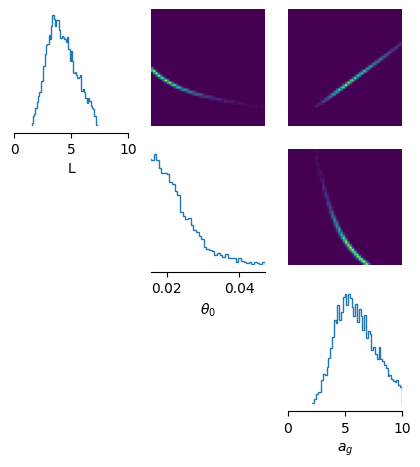

In [12]:
#x_o_1 = simulator([5, np.pi/100, 5])
x_o_1 = simulator([5, np.pi/200, 7])
print(x_o_1)
posterior_samples_1 = posterior.sample((10000,), x=x_o_1)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples_1, 
    labels = ['L',r'$\theta_0$','$a_g$'],
    limits = [[0,10],[np.pi/200,3*np.pi/200],[0,10]],
    truths = [5, np.pi/100, 5],
    figsize=(5, 5)
)
